In [1]:
import pickle
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, random, cv2
import sklearn
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_score


# data load and preprocessing

#### Load Cifar-10 dataset

In [19]:
# Read each batch file
def load_cifar10_batches(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding = 'bytes')
        data = batch[b'data']
        labels = batch[b'labels']
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return data, labels

In [20]:
# Load the training set
train_cifar10_data = []
train_cifar10_labels = []
for i in range(1, 6):
    data_batch, labels_batch = load_cifar10_batches(f'cifar-10-batches-py/data_batch_{i}')
    train_cifar10_data.append(data_batch)
    train_cifar10_labels += labels_batch
train_cifar10_data = np.concatenate(train_cifar10_data)
train_cifar10_labels = np.array(train_cifar10_labels)

# Load the test set
test_cifar10_data, test_cifar10_labels = load_cifar10_batches('cifar-10-batches-py/test_batch')

print("Train cifar10_Data Shape:", train_cifar10_data.shape)
print("Test cifar10_Data Shape:", test_cifar10_data.shape)

Train cifar10_Data Shape: (50000, 32, 32, 3)
Test cifar10_Data Shape: (10000, 32, 32, 3)


In [21]:
# 这里我们用 20% 的训练数据做验证集，并且保持分层采样
X_cifar10_train, X_cifar10_val, y_cifar10_train, y_cifar10_val = train_test_split(
    train_cifar10_data,
    train_cifar10_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_cifar10_labels
)

print("After split:")
print("  Train:", X_cifar10_train.shape, y_cifar10_train.shape)
print("  Val  :", X_cifar10_val.shape,   y_cifar10_val.shape)
print("  Test :", test_cifar10_data.shape, len(test_cifar10_labels))

After split:
  Train: (40000, 32, 32, 3) (40000,)
  Val  : (10000, 32, 32, 3) (10000,)
  Test : (10000, 32, 32, 3) 10000


#### Load Icub World dataset

In [4]:
def collect_image_paths(root_dir, exts=('.png','.jpg','.jpeg','.ppm')):
    classes = sorted(d for d in os.listdir(root_dir)
                     if os.path.isdir(os.path.join(root_dir, d)))
    img_paths, labels = [], []
    for cls_idx, cls in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls)
        # 列出该 class 目录下所有条目
        for entry in os.listdir(cls_dir):
            path = os.path.join(cls_dir, entry)
            # 如果是子文件夹，就走老逻辑
            if os.path.isdir(path):
                for fname in os.listdir(path):
                    if fname.lower().endswith(exts):
                        img_paths.append(os.path.join(path, fname))
                        labels.append(cls_idx)
            # 如果 entry 本身就是图片，就直接收集
            elif entry.lower().endswith(exts):
                img_paths.append(path)
                labels.append(cls_idx)
    return img_paths, labels, classes


In [5]:
# 1. 读取训练集所有路径和标签
train_icub_root = "./iCubWorld/train"
train_icub_data, train_icub_labels, train_icub_classes = collect_image_paths(train_icub_root)
print(f"Found {len(train_icub_data)} train images across {len(train_icub_classes)} classes:")
print(train_icub_classes)

# 3. 读取测试集路径和标签
test_icub_root = "./iCubWorld/test/categorization"
test_icub_data, test_icub_labels, test_icub_classes = collect_image_paths(test_icub_root)

# 用训练集的 class 排序，统一编码
class_to_idx = {cls_name: i for i, cls_name in enumerate(train_icub_classes)}
test_icub_labels = [class_to_idx[os.path.basename(os.path.dirname(p))] for p in test_icub_data]
print(test_icub_classes)
print(f"Found {len(test_icub_data)} test images")


Found 6002 train images across 10 classes:
['bananas', 'bottles', 'boxes', 'bread', 'cans', 'lemons', 'pears', 'peppers', 'potatoes', 'yogurt']
['bananas', 'bottles', 'boxes', 'bread', 'cans', 'lemons', 'pears', 'peppers', 'potatoes', 'yogurt']
Found 2001 test images


In [6]:
X_icub_train, X_icub_val, y_icub_train, y_icub_val = train_test_split(
    train_icub_data,
    train_icub_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_icub_labels
)
print("After split:")
print("  Train:", len(X_icub_train), len(y_icub_train))
print("  Val  :", len(X_icub_val),   len(y_icub_val))
print("  Test :", len(test_icub_data), len(test_icub_labels))

After split:
  Train: 4801 4801
  Val  : 1201 1201
  Test : 2001 2001


In [7]:
def preprocess(data, apply_blur=True):
    gray_images = []
    for x in tqdm(data, desc="Preprocessing"):
        # gray scale
        if isinstance(x, str):
            img = cv2.imread(x)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = x
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_images.append(gray)
    return gray_images  
# for cifar10
# train_cifar10_gray = preprocess(X_cifar10_train)
# val_cifar10_gray = preprocess(X_cifar10_val)
# test_cifar10_gray = preprocess(test_cifar10_data)
# for icubworld
train_icub_gray = preprocess(X_icub_train)
val_icub_gray = preprocess(X_icub_val)
test_icub_gray = preprocess(test_icub_data)

Preprocessing: 100%|██████████| 2001/2001 [00:01<00:00, 1962.04it/s]


# 方法实现

## SIFT

In [8]:
# SIFT
def extract_sift_features(images, nf, ct):
    sift = cv2.SIFT_create(nfeatures=nf, contrastThreshold=ct)
    descriptors_list = []
    valid_indices = []

    for i, img in enumerate(tqdm(images, desc="sift extraction")):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
            valid_indices.append(i)

    if len(descriptors_list) > 0:
        total_descriptors = np.vstack(descriptors_list)
    else:
        total_descriptors = np.array([])

    return descriptors_list, total_descriptors, valid_indices

# Harris + SIFT

In [9]:
# Harris detect keypoints and sift do computing
def harris(images, blocksize, ksize, k, thresh_ratio):
    sift = cv2.SIFT_create()
    descriptors_list = []
    valid_indices = []
    for i, img in enumerate(tqdm(images, desc = "harris + SIFT")):
        dst = cv2.cornerHarris(img, blocksize, ksize, k)
        dst = cv2.dilate(dst, None)
        thresh_val = dst.max() * thresh_ratio
        ys, xs = np.where(dst > thresh_val)
        keypoints = [cv2.KeyPoint(float(x), float(y), ksize * 2)
                     for y, x in zip(ys, xs)]
        if not keypoints:
            continue
        _, descriptors = sift.compute(img, keypoints)
        if descriptors is None:
            continue
        descriptors_list.append(descriptors)
        valid_indices.append(i)
    if descriptors_list:
        total_descriptors = np.vstack(descriptors_list)
    else:
        total_descriptors = np.array([])
    return descriptors_list, total_descriptors, valid_indices

## BOW

In [10]:
# build a visual dictionary using KMeans.
def build_vocabulary(total_descriptors, K):
    Kmeans = MiniBatchKMeans(n_clusters=K, batch_size=1000, random_state=42, verbose=1)
    # Kmeans = KMeans(n_clusters=K)
    print("KMeans")
    kmeans = Kmeans.fit(total_descriptors)
    return kmeans

# Encode the descriptor of an image into a BoW histogram
def bow_histogram(descriptors, kmeans, num_clusters):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(num_clusters)

    words = kmeans.predict(descriptors)
    histogram, _ = np.histogram(words, bins=np.arange(num_clusters + 1))

    histogram = histogram.astype("float")
    histogram /= (histogram.sum() + 1e-7)
    return histogram

# All histograms are returned
def encode_images(descriptors_list, kmeans, num_clusters):
    all_histograms = []
    for descriptors in descriptors_list:
        hist = bow_histogram(descriptors, kmeans, num_clusters)
        all_histograms.append(hist)

    return np.array(all_histograms)

## SVM

In [11]:
# train SVM classifier using bow feature
def train_svm_classifier(train_histograms, train_labels, C):
    X_train = train_histograms
    y_train = np.array(train_labels)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    print("X_train shape:", X_train_scaled.shape)
    print("y_train shape:", y_train.shape)
    svm = LinearSVC(C=C, max_iter=5000)
    svm.fit(X_train_scaled, y_train)
    return svm, scaler

# evaluate SVM
def evaluate_svm(X_test_bow, y_test, scaler, svm, batch_size=100):
    # normalization
    X_test_scaled = scaler.transform(X_test_bow)

    y_pred = svm.predict(X_test_scaled)

    # print Accuracy
    for i in range(batch_size, len(y_pred) + 1, batch_size):
        acc_now = accuracy_score(y_test[:i], y_pred[:i])
        print(f"[Processed {i} samples] Current Accuracy: {acc_now * 100:.2f}%")

    # Final accuracy
    final_acc = accuracy_score(y_test, y_pred)
    print(f"Final Test Accuracy: {final_acc * 100:.2f}%")
    return final_acc

# 调参


## SIFT参数

In [132]:
# SIFT contrastThireshold and nfeatures, BoW visual dictionary size, SVM regularization factor
def tune_hyperparams_sift(
    gray_train, y_train, 
    gray_val,   y_val,
    ct_list, nf_list, K_list, C_list,
    batch_size_kmeans=500,
    random_state=42
):
    results = []
    total_configs = len(ct_list) * len(nf_list) * len(K_list) * len(C_list)
    for ct, nf, K, C in tqdm(itertools.product(ct_list, nf_list, K_list, C_list),
                             total=total_configs, desc="Hyperparam Tuning"):
        # 1 extract SIFT features on training subset
        desc_train, total_desc, idx_train = extract_sift_features(gray_train, nf, ct)
        if total_desc.size == 0:
            continue
        # 2 Build a dictionary and encode training set
        kmeans = MiniBatchKMeans(n_clusters=K, batch_size=batch_size_kmeans,
                                 random_state=random_state).fit(total_desc)
        X_train_bow = encode_images(desc_train, kmeans, K)
        y_train_use = np.array(y_train)[idx_train]
        # 3 train SVM
        scaler = StandardScaler().fit(X_train_bow)
        X_tr_scaled = scaler.transform(X_train_bow)
        svm = LinearSVC(C=C, max_iter=5000).fit(X_tr_scaled, y_train_use)
        # 4 extract features on val dataset
        desc_val, _, idx_val = extract_sift_features(gray_val, nf, ct)
        if not idx_val:
            continue
        X_val_bow = encode_images(desc_val, kmeans, K)
        y_val_use = np.array(y_val)[idx_val]
        # 5 Validation set prediction and compute accuracy
        X_val_scaled = scaler.transform(X_val_bow)
        val_acc = accuracy_score(y_val_use, svm.predict(X_val_scaled))
        # record result
        results.append({
            'contrastThreshold': ct,
            'nfeatures':         nf,
            'K':                 K,
            'C':                 C,
            'val_acc':           val_acc
        })
    df_results = pd.DataFrame(results).sort_values(by='val_acc', ascending=False).reset_index(drop=True)
    best_params = df_results.iloc[0].to_dict() if not df_results.empty else {}
    return df_results, best_params

In [134]:
subset_gray_cifar10, _, subset_labels_cifar10, _ = train_test_split(
    train_cifar10_gray, y_cifar10_train,
    test_size=0.8, 
    random_state=42,
    stratify=y_cifar10_train
)
df_cifar10, best_cifar10 = tune_hyperparams_sift(
    gray_train=subset_gray_cifar10, y_train=subset_labels_cifar10,
    gray_val=val_cifar10_gray,      y_val=y_cifar10_val,
    ct_list=[0.005, 0.02], nf_list=[0, 500],
    K_list=[500, 1000], C_list=[0.1, 1, 10, 100]
)

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2368.98it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2440.99it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2481.35it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2495.67it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2470.14it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2395.30it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2438.00it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2337.06it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2358.79it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2188.99it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2399.37it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2023.65it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2283.09it/s]

sift extraction: 100%|██████████| 8000/8000 [00:03<00:00, 2249.2

In [135]:
print(df_cifar10)
print(best_cifar10)

    contrastThreshold  nfeatures     K      C   val_acc
0               0.005          0   500    0.1  0.232163
1               0.005        500   500  100.0  0.232163
2               0.005          0   500   10.0  0.232163
3               0.005          0   500  100.0  0.232163
4               0.005        500   500    0.1  0.232163
5               0.005        500   500   10.0  0.232163
6               0.005          0   500    1.0  0.232062
7               0.005        500   500    1.0  0.232062
8               0.020        500   500    1.0  0.222200
9               0.020        500   500    0.1  0.222200
10              0.020          0   500    1.0  0.222200
11              0.020          0   500    0.1  0.222200
12              0.020        500   500  100.0  0.222100
13              0.020          0   500   10.0  0.222100
14              0.020          0   500  100.0  0.222100
15              0.020        500   500   10.0  0.222100
16              0.020        500  1000    0.1  0

In [110]:
subset_gray_icub, _, subset_labels_icub, _ = train_test_split(
    train_icub_gray, y_icub_train,
    test_size=0.2, 
    random_state=42,
    stratify=y_icub_train
)
df_icub, best_icub = tune_hyperparams_sift(
    gray_train=train_icub_gray, y_train=y_icub_train,
    gray_val=val_icub_gray,      y_val=y_icub_val,
    ct_list=[0.005, 0.02], nf_list=[0, 500],
    K_list=[500, 1000], C_list=[0.1, 1, 10, 100]
)

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 275.84it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 272.10it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 275.33it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 280.27it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 274.70it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 278.14it/s]

sift extraction: 100%|██████████| 4801/4801 [00:16<00:00, 283.05it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 278.74it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 275.95it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 275.91it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 279.29it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 274.32it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 275.15it/s]

sift extraction: 100%|██████████| 4801/4801 [00:17<00:00, 278.76it/s]

sift e

In [111]:
print(df_icub)
print(best_icub)

    contrastThreshold  nfeatures     K      C   val_acc
0               0.020        500  1000    0.1  0.587011
1               0.020          0  1000    0.1  0.587011
2               0.020          0   500    0.1  0.586178
3               0.020        500   500    0.1  0.586178
4               0.020          0   500    1.0  0.582848
5               0.020        500   500    1.0  0.582848
6               0.005          0  1000    0.1  0.580350
7               0.005        500  1000    0.1  0.580350
8               0.020        500   500   10.0  0.577852
9               0.020          0   500   10.0  0.577852
10              0.020        500  1000   10.0  0.577019
11              0.020          0  1000   10.0  0.577019
12              0.020        500   500  100.0  0.575354
13              0.020          0   500  100.0  0.575354
14              0.020          0  1000  100.0  0.573689
15              0.020        500  1000  100.0  0.573689
16              0.005        500  1000    1.0  0

In [14]:
# Harris thresh, BoW visual dictionary size, SVM regularization factor
def tune_hyperparams_harris(
    train_gray, val_gray,
    y_train, y_val,
    thresh_list,
    K_list,
    C_list,
    blocksize=2, ksize=3, k=0.04
):
    results = []
    for thresh in tqdm(thresh_list, desc="thresh_ratio"):
        # 1 extract features
        desc_tr, tot_desc_tr, idx_tr = harris(
            train_gray,
            blocksize=blocksize, ksize=ksize,
            k=k, thresh_ratio=thresh
        )
        if tot_desc_tr.size == 0:
            continue

        for K in tqdm(K_list, desc="K clusters", leave=False):
            # build vocabulary and encode training set
            kmeans = MiniBatchKMeans(
                n_clusters=K, batch_size=1000,
                random_state=42, verbose=0
            ).fit(tot_desc_tr)
            X_tr = encode_images(desc_tr, kmeans, K)
            y_tr = np.array(y_train)[idx_tr]

            # (4) normalization
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)

            for C in tqdm(C_list, desc="C values", leave=False):
                # (5) train SVM
                svm = LinearSVC(C=C, max_iter=5000).fit(X_tr_s, y_tr)

                # (6) evaluate on val
                desc_val, _, idx_val = harris(
                    val_gray,
                    blocksize=blocksize, ksize=ksize,
                    k=k, thresh_ratio=thresh
                )
                if not idx_val:
                    continue
                X_val = encode_images(desc_val, kmeans, K)
                X_val_s = scaler.transform(X_val)
                y_val_u = np.array(y_val)[idx_val]

                val_acc = accuracy_score(
                    y_val_u, svm.predict(X_val_s)
                )
                results.append({
                    'thresh_ratio': thresh,
                    'K': K,
                    'C': C,
                    'val_acc': val_acc
                })
    # sort and print best
    results = sorted(results, key=lambda x: x['val_acc'], reverse=True)
    best = results[0] if results else None
    print("All configs sorted by val_acc:")
    for r in results:
        print(r)
    print("\nBest config:", best)
    return results, best

In [138]:
subset_gray_h_cifar, _, subset_labels_h_cifar, _ = train_test_split(
    train_cifar10_gray, y_cifar10_train,
    test_size=0.8, 
    random_state=42,
    stratify=y_cifar10_train
)
results_cifar, best_cifar = tune_hyperparams_harris(
    train_gray=subset_gray_h_cifar,
    val_gray=val_cifar10_gray,
    y_train=subset_labels_h_cifar,
    y_val=y_cifar10_val,
    thresh_list = [0.005, 0.02],
    K_list=[200, 500],
    C_list=[0.1, 1, 10]
)

harris + SIFT: 100%|██████████| 8000/8000 [00:09<00:00, 868.44it/s]

K clusters:   0%|          | 0/2 [00:00<?, ?it/s]

C values:   0%|          | 0/3 [00:00<?, ?it/s]


harris + SIFT:   0%|          | 0/10000 [00:00<?, ?it/s]


harris + SIFT:   1%|          | 93/10000 [00:00<00:10, 925.78it/s]


harris + SIFT:   2%|▏         | 186/10000 [00:00<00:10, 922.26it/s]


harris + SIFT:   3%|▎         | 281/10000 [00:00<00:10, 932.11it/s]


harris + SIFT:   4%|▍         | 375/10000 [00:00<00:10, 932.14it/s]


harris + SIFT:   5%|▍         | 469/10000 [00:00<00:10, 928.98it/s]


harris + SIFT:   6%|▌         | 566/10000 [00:00<00:10, 936.90it/s]


harris + SIFT:   7%|▋         | 664/10000 [00:00<00:09, 949.39it/s]


harris + SIFT:   8%|▊         | 763/10000 [00:00<00:09, 960.08it/s]


harris + SIFT:   9%|▊         | 860/10000 [00:00<00:10, 836.14it/s]


harris + SIFT:  10%|▉         | 959/10000 [00:01<00:10, 876.82it/s]


harris + SIFT:  10%|█         | 1050/10000 [00:01<00:10, 832.82it/s]


h

All configs sorted by val_acc:
{'thresh_ratio': 0.005, 'K': 500, 'C': 0.1, 'val_acc': 0.392}
{'thresh_ratio': 0.005, 'K': 500, 'C': 10, 'val_acc': 0.3909}
{'thresh_ratio': 0.005, 'K': 500, 'C': 1, 'val_acc': 0.3907}
{'thresh_ratio': 0.005, 'K': 200, 'C': 0.1, 'val_acc': 0.3736}
{'thresh_ratio': 0.005, 'K': 200, 'C': 1, 'val_acc': 0.3734}
{'thresh_ratio': 0.005, 'K': 200, 'C': 10, 'val_acc': 0.3734}
{'thresh_ratio': 0.02, 'K': 500, 'C': 0.1, 'val_acc': 0.3718}
{'thresh_ratio': 0.02, 'K': 500, 'C': 1, 'val_acc': 0.3709}
{'thresh_ratio': 0.02, 'K': 500, 'C': 10, 'val_acc': 0.3704}
{'thresh_ratio': 0.02, 'K': 200, 'C': 1, 'val_acc': 0.3609}
{'thresh_ratio': 0.02, 'K': 200, 'C': 10, 'val_acc': 0.3609}
{'thresh_ratio': 0.02, 'K': 200, 'C': 0.1, 'val_acc': 0.3606}

Best config: {'thresh_ratio': 0.005, 'K': 500, 'C': 0.1, 'val_acc': 0.392}


In [15]:
subset_gray_h_icub, _, subset_labels_h_icub, _ = train_test_split(
    train_icub_gray, y_icub_train,
    test_size=0.8, 
    random_state=42,
    stratify=y_icub_train
)
# 对 CIFAR-10 调参
results_icub, best_icub = tune_hyperparams_harris(
    train_gray=subset_gray_h_icub,
    val_gray=val_icub_gray,
    y_train=subset_labels_h_icub,
    y_val=y_icub_val,
    thresh_list = [0.005, 0.02],
    K_list=[200, 500],
    C_list=[0.1, 1, 10]
)

harris + SIFT: 100%|██████████| 960/960 [00:08<00:00, 118.79it/s]

K clusters:   0%|          | 0/2 [00:00<?, ?it/s]

C values:   0%|          | 0/3 [00:00<?, ?it/s]


harris + SIFT:   0%|          | 0/1201 [00:00<?, ?it/s]


harris + SIFT:   1%|          | 10/1201 [00:00<00:12, 98.84it/s]


harris + SIFT:   2%|▏         | 24/1201 [00:00<00:10, 116.74it/s]


harris + SIFT:   3%|▎         | 37/1201 [00:00<00:09, 121.38it/s]


harris + SIFT:   4%|▍         | 50/1201 [00:00<00:09, 116.53it/s]


harris + SIFT:   5%|▌         | 63/1201 [00:00<00:09, 120.61it/s]


harris + SIFT:   6%|▋         | 76/1201 [00:00<00:09, 115.15it/s]


harris + SIFT:   7%|▋         | 89/1201 [00:00<00:09, 119.00it/s]


harris + SIFT:   8%|▊         | 101/1201 [00:00<00:09, 118.24it/s]


harris + SIFT:  10%|▉         | 115/1201 [00:00<00:08, 124.59it/s]


harris + SIFT:  11%|█         | 130/1201 [00:01<00:08, 131.09it/s]


harris + SIFT:  12%|█▏        | 146/1201 [00:01<00:07, 138.25it/s]


harris + SIFT:  13%|█▎ 

All configs sorted by val_acc:
{'thresh_ratio': 0.005, 'K': 500, 'C': 0.1, 'val_acc': 0.630308076602831}
{'thresh_ratio': 0.02, 'K': 500, 'C': 0.1, 'val_acc': 0.6169858451290591}
{'thresh_ratio': 0.005, 'K': 500, 'C': 1, 'val_acc': 0.6161532056619484}
{'thresh_ratio': 0.02, 'K': 500, 'C': 1, 'val_acc': 0.6053288925895087}
{'thresh_ratio': 0.005, 'K': 500, 'C': 10, 'val_acc': 0.604496253122398}
{'thresh_ratio': 0.02, 'K': 500, 'C': 10, 'val_acc': 0.5995004163197336}
{'thresh_ratio': 0.005, 'K': 200, 'C': 0.1, 'val_acc': 0.5620316402997502}
{'thresh_ratio': 0.005, 'K': 200, 'C': 1, 'val_acc': 0.5154038301415487}
{'thresh_ratio': 0.005, 'K': 200, 'C': 10, 'val_acc': 0.5104079933388843}
{'thresh_ratio': 0.02, 'K': 200, 'C': 0.1, 'val_acc': 0.507910074937552}
{'thresh_ratio': 0.02, 'K': 200, 'C': 1, 'val_acc': 0.466278101582015}
{'thresh_ratio': 0.02, 'K': 200, 'C': 10, 'val_acc': 0.45545378850957535}

Best config: {'thresh_ratio': 0.005, 'K': 500, 'C': 0.1, 'val_acc': 0.630308076602831}


## Training

In [136]:
sift_descriptors_list_train_cifar10, total_descriptors_train_cifar10, valid_indices_train_cifar10 = extract_sift_features(train_cifar10_gray, 0, 0.005)
sift_descriptors_test_list_cifar10, _, valid_test_indices_cifar10 = extract_sift_features(test_cifar10_gray, 0, 0.005)
K = 500
kmeans = build_vocabulary(total_descriptors_train_cifar10, K)
sift_cifar10_X_train_bow = encode_images(sift_descriptors_list_train_cifar10, kmeans, K)
sift_cifar10_X_test_bow = encode_images(sift_descriptors_test_list_cifar10, kmeans, K)
y_train = np.array(y_cifar10_train)[valid_indices_train_cifar10]
y_test  = np.array(test_cifar10_labels)[valid_test_indices_cifar10]
svm, scaler = train_svm_classifier(sift_cifar10_X_train_bow, y_train, C=0.1)

final_acc = evaluate_svm(
    X_test_bow=sift_cifar10_X_test_bow,
    y_test=y_test,
    scaler=scaler,
    svm=svm,
    batch_size=100
)

sift extraction: 100%|██████████| 10000/10000 [00:04<00:00, 2292.28it/s]


KMeans
Init 1/1 with method k-means++
Inertia for init 1/1: 347858432.0
[MiniBatchKMeans] Reassigning 110 cluster centers.
Minibatch step 1/59067: mean batch inertia: 114754.312
Minibatch step 2/59067: mean batch inertia: 102101.456, ewa inertia: 102101.456
Minibatch step 3/59067: mean batch inertia: 94305.04, ewa inertia: 102075.05789611973
Minibatch step 4/59067: mean batch inertia: 91310.288, ewa inertia: 102038.60915942263
Minibatch step 5/59067: mean batch inertia: 89876.056, ewa inertia: 101997.42762912053
Minibatch step 6/59067: mean batch inertia: 88637.2, ewa inertia: 101952.19085919732
Minibatch step 7/59067: mean batch inertia: 88324.616, ewa inertia: 101906.04887077991
Minibatch step 8/59067: mean batch inertia: 87810.904, ewa inertia: 101858.32372392957
Minibatch step 9/59067: mean batch inertia: 85992.664, ewa inertia: 101804.60374111678
Minibatch step 10/59067: mean batch inertia: 86196.328, ewa inertia: 101751.75524195949
[MiniBatchKMeans] Reassigning 86 cluster centers

In [112]:
sift_descriptors_list_train_icub, total_descriptors_train_icub, valid_indices_train_icub = extract_sift_features(train_icub_gray, 0, 0.02)
sift_descriptors_test_list_icub, _, valid_test_indices_icub = extract_sift_features(test_icub_gray, 0, 0.02)
K = 1000
kmeans = build_vocabulary(total_descriptors_train_icub, K)
sift_icub_X_train_bow = encode_images(sift_descriptors_list_train_icub, kmeans, K)
sift_icub_X_test_bow = encode_images(sift_descriptors_test_list_icub, kmeans, K)
y_train_sift_icub = np.array(y_icub_train)[valid_indices_train_icub]
y_test_sift_icub  = np.array(test_icub_labels)[valid_test_indices_icub]
svm, scaler = train_svm_classifier(sift_icub_X_train_bow, y_train_sift_icub, C=0.1)

final_acc_sift_icub = evaluate_svm(
    X_test_bow=sift_icub_X_test_bow,
    y_test=y_test_sift_icub,
    scaler=scaler,
    svm=svm,
    batch_size=100
)

sift extraction: 100%|██████████| 2001/2001 [00:06<00:00, 300.51it/s]


KMeans
Init 1/1 with method k-means++
Inertia for init 1/1: 260856576.0
[MiniBatchKMeans] Reassigning 485 cluster centers.
Minibatch step 1/83052: mean batch inertia: 88274.272
Minibatch step 2/83052: mean batch inertia: 85694.568, ewa inertia: 85694.568
Minibatch step 3/83052: mean batch inertia: 78380.168, ewa inertia: 85676.95399626018
Minibatch step 4/83052: mean batch inertia: 74314.944, ewa inertia: 85649.59283381815
Minibatch step 5/83052: mean batch inertia: 76568.144, ewa inertia: 85627.72355216526
Minibatch step 6/83052: mean batch inertia: 72976.528, ewa inertia: 85597.2578672466
Minibatch step 7/83052: mean batch inertia: 71690.512, ewa inertia: 85563.76865778111
Minibatch step 8/83052: mean batch inertia: 71267.792, ewa inertia: 85529.34213116039
Minibatch step 9/83052: mean batch inertia: 69036.56, ewa inertia: 85489.6254180823
Minibatch step 10/83052: mean batch inertia: 67935.512, ewa inertia: 85447.35288453268
Minibatch step 11/83052: mean batch inertia: 66796.12, ewa 

In [139]:
blocksize=2
ksize=3
k=0.04
thresh_ratio=0.005

harris_descriptors_list_train_cifar10, harris_total_descriptors_train_cifar10, harris_valid_indices_train_cifar10 \
    = harris(train_cifar10_gray, blocksize=blocksize, ksize=ksize, k=k, thresh_ratio=thresh_ratio)
harris_descriptors_test_list_cifar10, _, harris_valid_test_indices_cifar10 \
    = harris(test_cifar10_gray, blocksize=blocksize, ksize=ksize, k=k, thresh_ratio=thresh_ratio)

K = 500
kmeans = build_vocabulary(harris_total_descriptors_train_cifar10, K)

h_cifar10_X_train_bow = encode_images(harris_descriptors_list_train_cifar10, kmeans, K)
h_cifar10_X_val_bow = encode_images(harris_descriptors_test_list_cifar10, kmeans, K)

y_train_h_cifar10 = np.array(y_cifar10_train)[harris_valid_indices_train_cifar10]
y_test_h_cifar10  = np.array(test_cifar10_labels)[harris_valid_test_indices_cifar10]
svm, scaler = train_svm_classifier(h_cifar10_X_train_bow, y_train_h_cifar10, C=0.1)

final_acc_harris_cifar10 = evaluate_svm(
    X_test_bow=h_cifar10_X_val_bow,
    y_test=y_test_h_cifar10,
    scaler=scaler,
    svm=svm,
    batch_size=100
)

harris + SIFT: 100%|██████████| 10000/10000 [00:14<00:00, 700.42it/s]


KMeans
Init 1/1 with method k-means++
Inertia for init 1/1: 320273760.0
[MiniBatchKMeans] Reassigning 102 cluster centers.
Minibatch step 1/1945950: mean batch inertia: 105752.08
Minibatch step 2/1945950: mean batch inertia: 91182.976, ewa inertia: 91182.976
Minibatch step 3/1945950: mean batch inertia: 85311.88, ewa inertia: 91182.37258318115
Minibatch step 4/1945950: mean batch inertia: 83939.728, ewa inertia: 91181.62820196946
Minibatch step 5/1945950: mean batch inertia: 81475.248, ewa inertia: 91180.63060406543
Minibatch step 6/1945950: mean batch inertia: 80074.104, ewa inertia: 91179.48910255502
Minibatch step 7/1945950: mean batch inertia: 80162.416, ewa inertia: 91178.35679485564
Minibatch step 8/1945950: mean batch inertia: 78828.376, ewa inertia: 91177.08749417923
Minibatch step 9/1945950: mean batch inertia: 79030.0, ewa inertia: 91175.83904637766
Minibatch step 10/1945950: mean batch inertia: 78289.2, ewa inertia: 91174.51458928498
Minibatch step 11/1945950: mean batch ine

In [13]:
blocksize=2
ksize=3
k=0.04
thresh_ratio=0.005

harris_descriptors_list_train_icub, harris_total_descriptors_train_icub, harris_valid_indices_train_icub \
    = harris(train_icub_gray, blocksize=blocksize, ksize=ksize, k=k, thresh_ratio=thresh_ratio)
harris_descriptors_test_list_icub, _, harris_valid_test_indices_icub \
    = harris(test_icub_gray, blocksize=blocksize, ksize=ksize, k=k, thresh_ratio=thresh_ratio)

K = 500
kmeans = build_vocabulary(harris_total_descriptors_train_icub, K)

h_icub_X_train_bow = encode_images(harris_descriptors_list_train_icub, kmeans, K)
h_icub_X_test_bow = encode_images(harris_descriptors_test_list_icub, kmeans, K)

y_train_h_icub = np.array(y_icub_train)[harris_valid_indices_train_icub]
y_test_h_icub  = np.array(test_icub_labels)[harris_valid_test_indices_icub]
svm, scaler = train_svm_classifier(h_icub_X_train_bow, y_train_h_icub, C=0.1)

final_acc_harris_icub = evaluate_svm(
    X_test_bow=h_icub_X_test_bow,
    y_test=y_test_h_icub,
    scaler=scaler,
    svm=svm,
    batch_size=100
)

harris + SIFT: 100%|██████████| 2001/2001 [00:15<00:00, 132.81it/s]


KMeans
Init 1/1 with method k-means++
Inertia for init 1/1: 311847456.0
[MiniBatchKMeans] Reassigning 112 cluster centers.
Minibatch step 1/1072791: mean batch inertia: 102177.032
Minibatch step 2/1072791: mean batch inertia: 91804.0, ewa inertia: 91804.0
Minibatch step 3/1072791: mean batch inertia: 86812.68, ewa inertia: 91803.06947088894
Minibatch step 4/1072791: mean batch inertia: 83053.856, ewa inertia: 91801.43835971324
Minibatch step 5/1072791: mean batch inertia: 80704.128, ewa inertia: 91799.3694940937
Minibatch step 6/1072791: mean batch inertia: 79839.024, ewa inertia: 91797.13973329685
Minibatch step 7/1072791: mean batch inertia: 78588.352, ewa inertia: 91794.67722608281
Minibatch step 8/1072791: mean batch inertia: 76103.944, ewa inertia: 91791.75201110147
Minibatch step 9/1072791: mean batch inertia: 77448.384, ewa inertia: 91789.07798469465
Minibatch step 10/1072791: mean batch inertia: 75459.816, ewa inertia: 91786.03372913925
[MiniBatchKMeans] Reassigning 52 cluster 

# 比较harris和sift

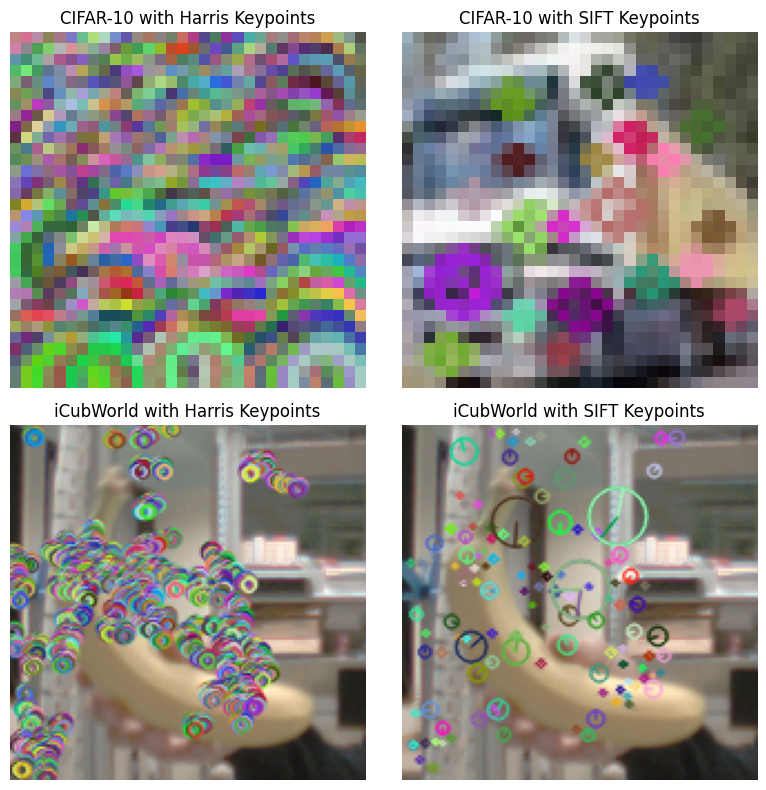

In [119]:
# 示例索引，可改为随机或特定索引
cifar_idx = 1
icub_idx = 1

# 原图
img_cifar = train_cifar10_data[cifar_idx]                  # RGB ndarray
img_icub  = cv2.cvtColor(cv2.imread(train_icub_data[icub_idx]), cv2.COLOR_BGR2RGB)

# 灰度
gray_cifar = train_cifar10_gray[cifar_idx]
gray_icub  = train_icub_gray[icub_idx]

# Harris 关键点函数
def get_harris_keypoints(gray, blocksize=2, ksize=3, k=0.04, thresh_ratio=0.01):
    dst = cv2.cornerHarris(gray, blocksize, ksize, k)
    dst = cv2.dilate(dst, None)
    ys, xs = np.where(dst > dst.max() * thresh_ratio)
    return [cv2.KeyPoint(float(x), float(y), ksize * 2)
            for y, x in zip(ys, xs)]

# 生成不同方法的 keypoints
kp_harris_cifar = get_harris_keypoints(gray_cifar)
kp_harris_icub  = get_harris_keypoints(gray_icub)
sift = cv2.SIFT_create()
kp_sift_cifar, _ = sift.detectAndCompute(gray_cifar, None)
kp_sift_icub,  _ = sift.detectAndCompute(gray_icub,  None)

# 绘制函数
def draw_keypoints(img, keypoints):
    return cv2.drawKeypoints(img, keypoints, None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 画图
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

axes[0,0].imshow(draw_keypoints(img_cifar, kp_harris_cifar))
axes[0,0].set_title("CIFAR-10 with Harris Keypoints")
axes[0,0].axis('off')

axes[0,1].imshow(draw_keypoints(img_cifar, kp_sift_cifar))
axes[0,1].set_title("CIFAR-10 with SIFT Keypoints")
axes[0,1].axis('off')

axes[1,0].imshow(draw_keypoints(img_icub, kp_harris_icub))
axes[1,0].set_title("iCubWorld with Harris Keypoints")
axes[1,0].axis('off')

axes[1,1].imshow(draw_keypoints(img_icub, kp_sift_icub))
axes[1,1].set_title("iCubWorld with SIFT Keypoints")
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

In [40]:
# check
for idx, desc in enumerate(descriptors_list[:5]):  # 只看前5个，防止刷屏
    if desc is not None:
        print(f"Image {idx}: descriptors.shape = {desc.shape}")
    else:
        print(f"Image {idx}: No descriptors detected!")

Image 0: descriptors.shape = (16, 128)
Image 1: descriptors.shape = (22, 128)
Image 2: descriptors.shape = (16, 128)
Image 3: descriptors.shape = (13, 128)
Image 4: descriptors.shape = (20, 128)


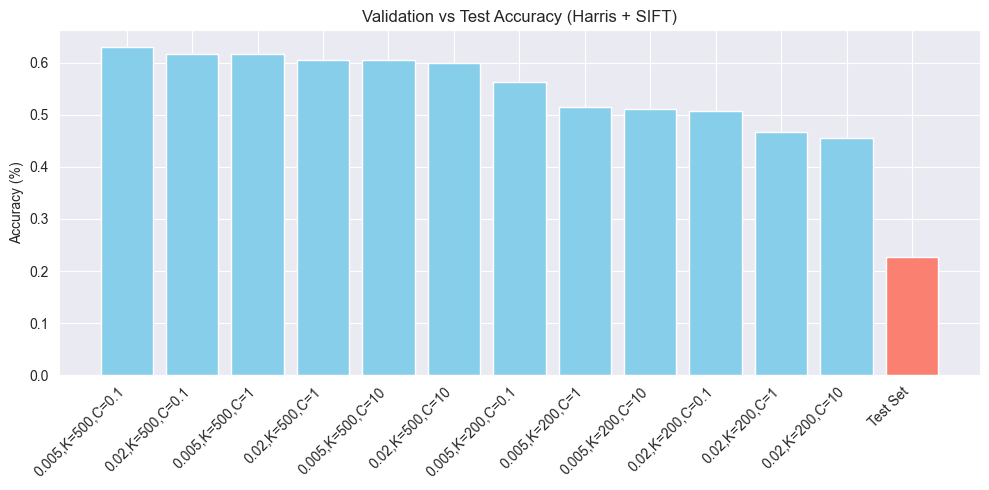

In [18]:
import matplotlib.pyplot as plt

# 假设你有验证集各组合的准确率
val_accs = [r['val_acc'] for r in results_icub]
labels = [f"{r['thresh_ratio']},K={r['K']},C={r['C']}" for r in results_icub]

# 测试集结果（例如某组最优参数的测试准确率）
test_acc = final_acc_harris_icub
labels.append("Test Set")
val_accs.append(test_acc)

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, val_accs, color=['skyblue'] * (len(labels) - 1) + ['salmon'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy (%)")
plt.title("Validation vs Test Accuracy (Harris + SIFT)")
plt.tight_layout()
plt.show()

